In [34]:
import requests
from lxml import etree
from typing import List
import arrow
import datetime
import pandas as pd
import numpy as np
import pathlib

In [3]:

def get_station_rad_df(end_dt_str: str) -> pd.DataFrame:
    """
        - 22-04-26
          测试爬取路径:
          http://www.ioc-sealevelmonitoring.org/bgraph.php?code=qing&output=tab&period=7
          根据日期爬取的路径:
          https://www.ioc-sealevelmonitoring.org/bgraph.php?code=shek&output=tab&period=30&endtime=2022-01-01
    :return:
    """
    print(f'准备爬取的end_dt为:{end_dt_str}')
    url = f'http://www.ioc-sealevelmonitoring.org/bgraph.php?code=qing&output=tab&period=30&endtime={end_dt_str}'
    html = requests.get(url)
    # 页面的内容
    html_content = html.text
    '''
        eg:
            <div align=center>
                <table border="1">
                    <th colspan="2">Tide gauge at Qinglan</th>
                    <tr><td>Time (UTC)</td><td class=field>rad(m)</td></tr>
                    <tr><td>2022-04-19 07:04:00</td><td>1
    '''
    # print(html_content)
    etree_htm = etree.HTML(html_content)
    # 定位到 table -> tbody
    # TODO:[-] 22-04-26 注意此处 由于本身页面有 html > body > div 而打印出来的只保留了 div 中的部分，缺失了前面的 html > body
    content = etree_htm.xpath('/html/body/div/table/tr')
    # print(content)
    table_name_index: int = -1
    list_station_rad: List[dict] = []

    for index, tr in enumerate(content):
        # print(tr)
        td_list = tr.xpath('td')
        '''
            <td>Time (UTC)</td><td class=field>rad(m)</td>
        '''
        if len(td_list) == 2:
            table_name = td_list[0].text
            if table_name == 'Time (UTC)':
                table_name_index = index
                # print(f'找到Time表头所在行index为:{table_name_index}')
            else:
                temp_dict = {}
                # <tr><td>2022-04-19 07:04:00</td><td>1
                # '2022-04-19 13:31:00'
                temp_dt_str: str = td_list[0].text
                # 2022-04-19T13:31:00+00:00
                # 注意时间为 UTC 时间
                temp_dt = arrow.get(temp_dt_str).datetime
                temp_rad_str: str = td_list[1].text
                # TODO:[-] 22-04-27 注意此处的 时间戳转为换 int ，不要使用 float
                # ts:1548260567 10位
                temp_dict = {'dt': temp_dt, 'rad': float(temp_rad_str), 'ts': arrow.get(temp_dt_str).int_timestamp}
                list_station_rad.append(temp_dict)
                # for td in td_list[index:]:
                #     print(td)
    # 将 list_station_red -> dataframe
    df: pd.DataFrame = None
    if len(list_station_rad) > 0:
        df = pd.DataFrame(list_station_rad)
        # 设置 ts 为索引
        df.set_index('ts')
        print('处理成功~')
    else:
        print('处理失败!')
    return df
    # pass


def get_target_year_all_dt(year: int) -> List[arrow.Arrow]:
    """
        获取指定年份的全部时间节点
        目前支持的时间间隔有 12h,1d,7d,30d
    :param year:
    :return: {'end_dt','per'} : 结束时间,时间间隔
    """
    # 当前年份的首日
    # year_first_day: datetime.datetime = datetime.datetime(year=year, month=1, day=1)
    # year_last_day: datetime.datetime = year_first_day + datetime.timedelta(days=365) + datetime.timedelta(seconds=-1)
    year_first_day: arrow.Arrow = arrow.get(year, 1, 1)
    year_last_day: arrow.Arrow = year_first_day.shift(years=1).shift(seconds=-1)
    list_dt: List[arrow.Arrow] = []
    temp_dt = year_first_day
    # temp_dt_arrow = arrow.get(temp_dt)
    # list_dt.append(temp_dt_arrow)
    while temp_dt <= year_last_day:
        temp_dt = temp_dt.shift(days=30)
        list_dt.append(temp_dt)
    return list_dt


def to_store(dir: str, file_name: str, df: pd.DataFrame = None):
    """
        将 df -> dir/file_name
    :param dir:
    :param file_name:
    :param df:
    :return:
    """
    dir_path: pathlib.Path = pathlib.Path(dir)
    full_path: pathlib.Path = dir_path / file_name
    if dir_path.exists() is not True:
        dir_path.mkdir(parents=True)
    if df is not None:
        df.to_csv(str(full_path))
    pass


def split_hour_df(df: pd.DataFrame):
    """
        对 df 只取整点数据
    :param df:
    :return:
    """
    df['ts']


def init_all_year_ser(year: int, freq: str = '1H'):
    """
        生成指定年份的整点series
    :param year:
    :return:
    """
    start_utc_ar = arrow.get(year, 1, 1)
    end_utc_ar = start_utc_ar.shift(days=365).shift(seconds=-1)

    dt_index = pd.date_range(start_utc_ar.datetime, end_utc_ar.datetime, freq=freq, name='ts')
    return dt_index


In [35]:
import pathlib

In [36]:
dir_path_str:str=r'D:\01Proj\OceanSpider\qinglan_2021_source'

In [37]:
dir_path=pathlib.Path(dir_path_str)
full_path_str:str=str(dir_path/'qinglan_2021_all.csv')

In [38]:
full_path_str

'D:\\01Proj\\OceanSpider\\qinglan_2021_source\\qinglan_2021_all.csv'

In [39]:
# step2: 数据标准化
# TODO:[*] 此处在提取整点时刻的数据时出错！,注意
read_df = pd.read_csv(full_path_str, parse_dates=['ts'])
# step2-1: 将爬取的原始数数据按照时间间隔为1min提取为分钟数据，并按照向上填充的方式进行填充
def str2int64(val: str):
    return np.int64(val)
def dt64ToTs(val64):
    """
        datetime64[ns] -> timestamp
    :param val:
    :return:
    """
    # 注意此处需要转换为 int 时间戳
    dt: datetime.datetime = pd.Timestamp(val64).to_pydatetime()
    return arrow.get(dt).int_timestamp

In [40]:
# 将时间戳 str -> int
read_df['ts'] = read_df.apply(lambda x: str2int64(x['ts']), axis=1)
read_df.set_index('ts')
# 生成 分钟级的索引列表
dt_split_minute_indexs = init_all_year_ser(2021, '60s')

In [41]:
# dt_split_minute_indexs

In [42]:
dt_split_minute_indexs[:5]

DatetimeIndex(['2021-01-01 00:00:00+00:00', '2021-01-01 00:01:00+00:00',
               '2021-01-01 00:02:00+00:00', '2021-01-01 00:03:00+00:00',
               '2021-01-01 00:04:00+00:00'],
              dtype='datetime64[ns, tzutc()]', name='ts', freq='60S')

In [43]:
# 注意其中的 dt 为 numpy.datetime64 类型！
dt_split_minute_stamp_df = pd.DataFrame(
    {'index': np.arange(0, len(dt_split_minute_indexs)), 'dt': dt_split_minute_indexs})
# 将匹配的全部分钟df加入时间戳
dt_split_minute_stamp_df['ts'] = dt_split_minute_stamp_df.apply(lambda x: dt64ToTs(x['dt']), axis=1)
# 设置 ts 为 index
dt_split_minute_stamp_df.set_index('ts')
# 将该年份所有分钟数据按照就近原则进行填充
reslt_all_df = pd.merge(dt_split_minute_stamp_df, read_df, on='ts', how='outer')
# reslt_all_df = reslt_all_df.fillna(method='ffill', axis=0)[['dt_x', 'ts', 'rad']]

In [44]:
# -----
# step2-2: 将分钟数据提取整点时刻并存储至新的文件
dt_split_hours_indexs = init_all_year_ser(2021)
# 整点时间标记df
dt_split_hours_stamp_df = pd.DataFrame(
    {'index': np.arange(0, len(dt_split_hours_indexs)), 'dt': dt_split_hours_indexs})
dt_split_hours_stamp_df['ts'] = dt_split_hours_stamp_df.apply(lambda x: dt64ToTs(x['dt']), axis=1)
dt_split_hours_stamp_df.set_index('ts')
# 将 read_df 与 dt_split_hours_stamp_df 合并
# TODO: [*] 22-04-27 注意 使用 how='outer' 时会出现 : ValueError: Timezones don't match. 'tzutc()' != 'UTC'
# 使用 int timestamp 后 ,merge 出现 : {ValueError}You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat
# 注意 read_df 中的 ts 是 str | dt_split_hours_stamp_df 中的 ts 是 int64
# 切记此处由于是需要将全部分钟数据提取为 整点数据，所以此处切记不要写成reslt_df，这有一个隐藏bug，注意！
reslt_df = pd.merge(dt_split_hours_stamp_df, reslt_all_df, on='ts', how='left')
# 注意此处不需要再执行填充操作了，因为上面的全分钟df已经包含了可能的全部时间
# reslt_df = reslt_df.fillna(method='ffill', axis=0)[['dt_x', 'ts', 'rad']]
# to_store('/opt/project', 'qinglan_2021_fill.csv', reslt_df)
# to_store('/opt/project', 'qinglan_2021_split_hours.csv', reslt_df)

In [45]:
import matplotlib.pyplot as plt
import datetime

---

In [27]:
start=datetime.datetime(2021,2,1)
end=datetime.datetime(2021,3,1)

In [28]:
start

datetime.datetime(2021, 2, 1, 0, 0)

In [29]:
start_pd_ts=pd.Timestamp(start)
type(start_pd_ts)

pandas._libs.tslibs.timestamps.Timestamp

In [30]:
end_pd_ts=pd.Timestamp(end)

In [31]:
start_ts=start_pd_ts.timestamp()
end_ts=end_pd_ts.timestamp()

In [33]:
type(end_ts)

float

In [114]:
start_dt64=np.datetime64(start)
start_dt64

numpy.datetime64('2021-02-01T00:00:00.000000')

In [115]:
reslt_all_df['ts']<end_ts

0          True
1          True
2          True
3          True
4          True
          ...  
548073    False
548074    False
548075    False
548076    False
548077    False
Name: ts, Length: 548078, dtype: bool

In [116]:
con1=reslt_all_df['ts']>start_ts
con2=reslt_all_df['ts']<end_ts

In [117]:
reslt_filter_df=reslt_all_df[con1&con2]
reslt_filter_df.head()

,index,dt_x,ts,Unnamed: 0,dt_y,rad
44641,44641.0,2021-02-01 00:01:00+00:00,1612137660,NaN,NaN,NaN
44642,44642.0,2021-02-01 00:02:00+00:00,1612137720,1060.0,2021-02-01 00:02:00+00:00,0.32
44643,44643.0,2021-02-01 00:03:00+00:00,1612137780,NaN,NaN,NaN
44644,44644.0,2021-02-01 00:04:00+00:00,1612137840,1061.0,2021-02-01 00:04:00+00:00,0.32
44645,44645.0,2021-02-01 00:05:00+00:00,1612137900,NaN,NaN,NaN


In [118]:
reslt_filter_df[-5:]

,index,dt_x,ts,Unnamed: 0,dt_y,rad
84955,84955.0,2021-02-28 23:55:00+00:00,1614556500,NaN,NaN,NaN
84956,84956.0,2021-02-28 23:56:00+00:00,1614556560,11863.0,2021-02-28 23:56:00+00:00,0.57
84957,84957.0,2021-02-28 23:57:00+00:00,1614556620,NaN,NaN,NaN
84958,84958.0,2021-02-28 23:58:00+00:00,1614556680,NaN,NaN,NaN
84959,84959.0,2021-02-28 23:59:00+00:00,1614556740,11864.0,2021-02-28 23:59:00+00:00,0.57


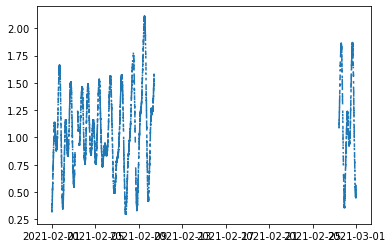

<Figure size 432x1296 with 0 Axes>

In [119]:
plt.plot(reslt_filter_df['dt_x'],reslt_filter_df['rad'])
plt.figure(figsize=(6,18))
plt.show()

不同的`limit`的效果

In [123]:
rad_inter_list=reslt_filter_df['rad'].interpolate(method='linear',limit=60)

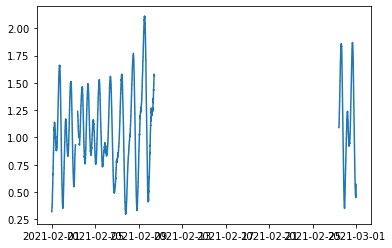

<Figure size 432x1296 with 0 Axes>

In [124]:
plt.plot(reslt_filter_df['dt_x'],rad_inter_list)
plt.figure(figsize=(6,18))
plt.show()

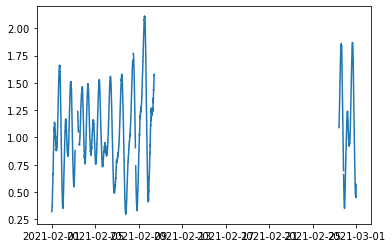

<Figure size 432x1296 with 0 Axes>

In [125]:
rad_inter_list=reslt_filter_df['rad'].interpolate(method='linear',limit=10)
plt.plot(reslt_filter_df['dt_x'],rad_inter_list)
plt.figure(figsize=(6,18))
plt.show()

---

### step3:获取该年份所有月份，并获取每个月份的起止时间，获取线性插值之后的 `dataframe`  
* 对`dataframe`进行差值使用了`.interpolate`方法，api参考:  
[Pandas DataFrame interpolate() 方法](https://cankaoshouce.com/pandas-ref-dataframe/pandas-df-interpolate.html)  
[pandas：超级方便的插值函数interpolate](https://zhuanlan.zhihu.com/p/357459373)  
[官方api](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html)  
* 使用拉格朗日差值填充 nan (未用到)  
[使用拉格朗日插值填充NaN值](https://zhuanlan.zhihu.com/p/477808536)

In [84]:
def inter_rad_month(start,end,df:pd.DataFrame)->pd.DataFrame:
    '''
        根据 起止时间 对 df 进行线性插值
    '''
    # step1: datetime.datetime -> timestamp
    start_ts=pd.Timestamp(start).timestamp()
    end_ts=pd.Timestamp(end).timestamp()
    con1=df['ts']>start_ts
    con2=df['ts']<end_ts
    reslt_filter_df=reslt_all_df[con1&con2]
    reslt_source_df=reslt_filter_df.copy()
    rad_inter_list=reslt_filter_df['rad'].interpolate(method='linear',limit=60,limit_direction ='backward')
    reslt_filter_df['rad']=rad_inter_list
    return [reslt_source_df,reslt_filter_df]
#     return reslt_filter_df
    

In [85]:
def get_month_range(year:int):
    '''
        获取该年份的每个月的起止时间
    '''
    list_month_range=[]
    for val_month in range(1,13):
        start_temp_arrrow=arrow.get(datetime.datetime(year,val_month,1))
        end_temp_arrow=start_temp_arrrow.shift(months=1)
        list_month_range.append([start_temp_arrrow.datetime,end_temp_arrow.datetime])
    return list_month_range
    

In [86]:
def to_store(dir: str, file_name: str, df: pd.DataFrame = None):
    """
        将 df -> dir/file_name
    :param dir:
    :param file_name:
    :param df:
    :return:
    """
    dir_path: pathlib.Path = pathlib.Path(dir)
    full_path: pathlib.Path = dir_path / file_name
    if dir_path.exists() is not True:
        dir_path.mkdir(parents=True)
    if df is not None:
        df.to_csv(str(full_path))
    pass

In [87]:
# test
list_months=get_month_range(2021)

In [50]:
list_months[0]

[datetime.datetime(2021, 1, 1, 0, 0, tzinfo=tzutc()),
 datetime.datetime(2021, 2, 1, 0, 0, tzinfo=tzutc())]

C:\Users\evase\Anaconda3\envs\new_oil_gdal\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


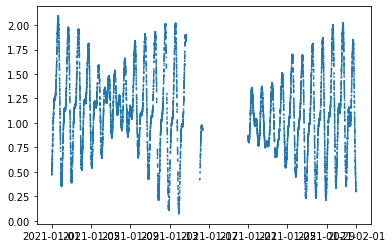

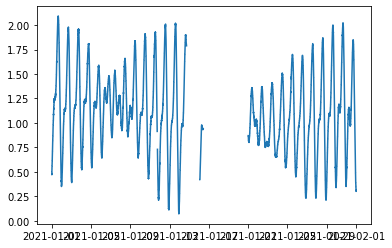

C:\Users\evase\Anaconda3\envs\new_oil_gdal\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


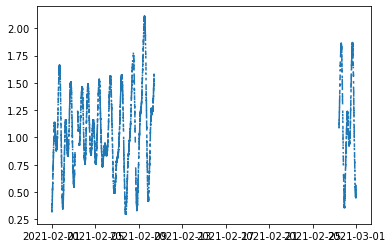

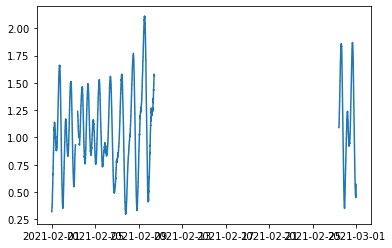

C:\Users\evase\Anaconda3\envs\new_oil_gdal\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


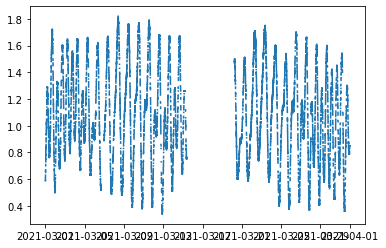

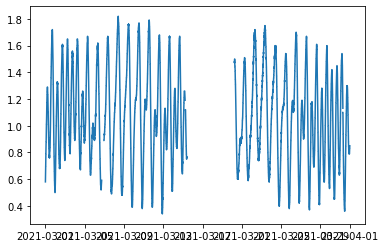

C:\Users\evase\Anaconda3\envs\new_oil_gdal\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


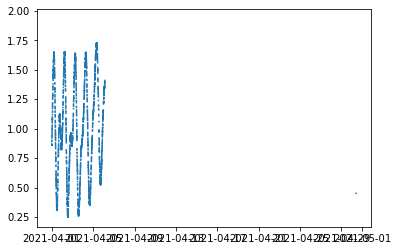

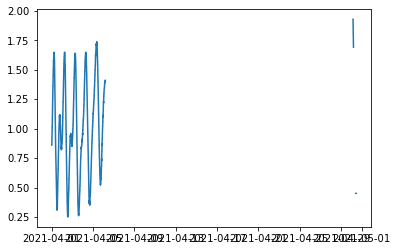

C:\Users\evase\Anaconda3\envs\new_oil_gdal\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


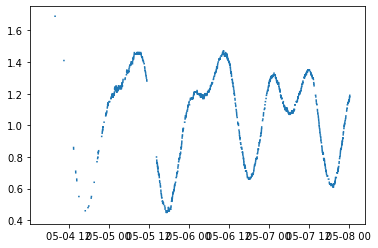

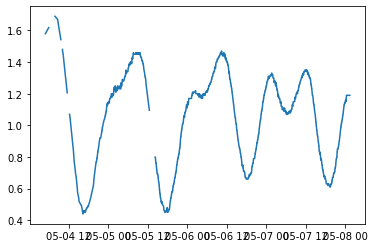

C:\Users\evase\Anaconda3\envs\new_oil_gdal\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


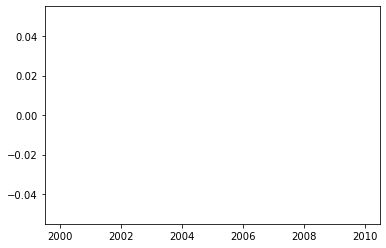

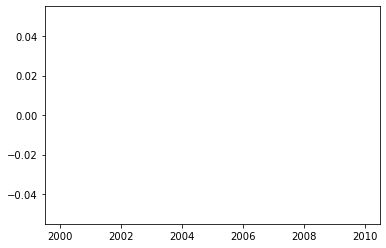

C:\Users\evase\Anaconda3\envs\new_oil_gdal\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


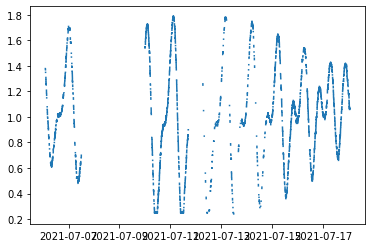

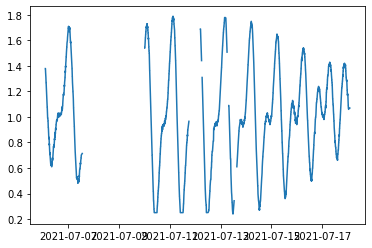

C:\Users\evase\Anaconda3\envs\new_oil_gdal\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


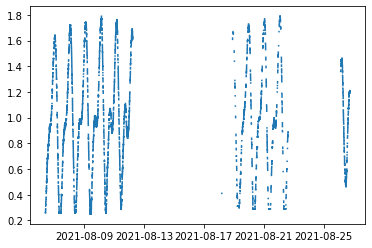

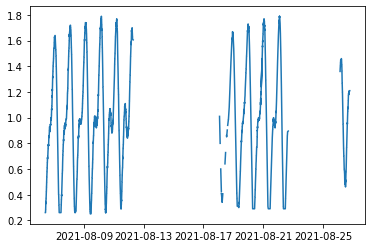

C:\Users\evase\Anaconda3\envs\new_oil_gdal\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


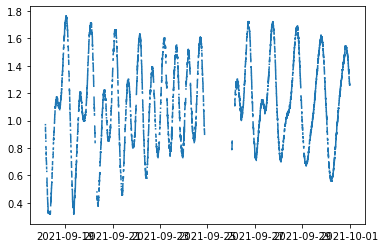

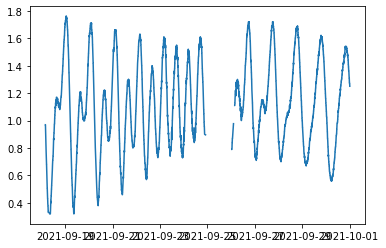

C:\Users\evase\Anaconda3\envs\new_oil_gdal\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


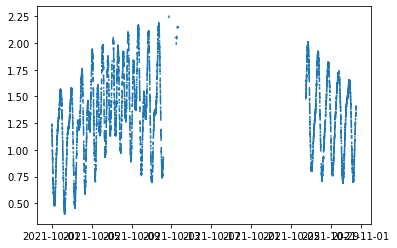

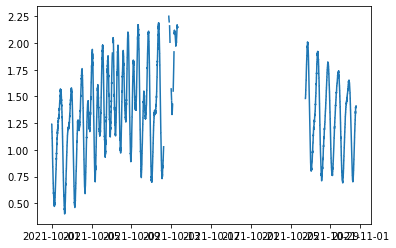

C:\Users\evase\Anaconda3\envs\new_oil_gdal\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


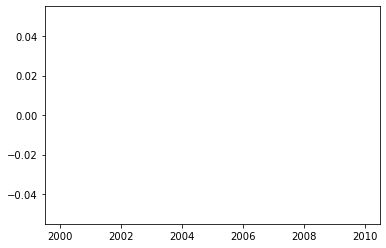

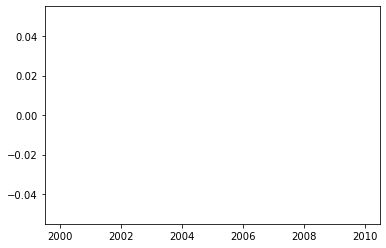

C:\Users\evase\Anaconda3\envs\new_oil_gdal\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


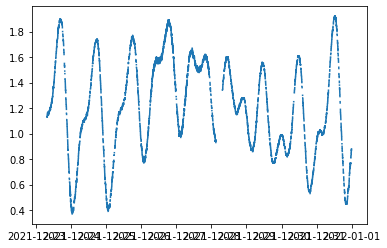

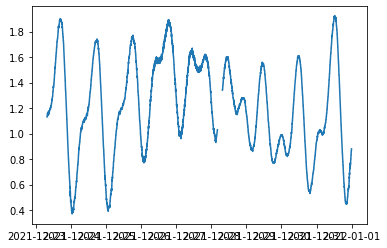

In [24]:
for temp in list_months:
    dfs=inter_rad_month(temp[0],temp[1],reslt_all_df)
    date_str:str=arrow.get(temp[0]).format('YYYYMM')
    plt.plot(dfs[0]['dt_x'],dfs[0]['rad'])
    plt.show()
    plt.plot(dfs[1]['dt_x'],dfs[1]['rad'])
    plt.show()
    # 分别存储每个月至source与inter两个文件中
    to_store(dir_path_str,f'qinglan_source_{date_str}.csv',dfs[0])
    to_store(dir_path_str,f'qinglan_converted_{date_str}.csv',dfs[1])
    

In [136]:
list_months

[[datetime.datetime(2021, 1, 1, 0, 0, tzinfo=tzutc()),
  datetime.datetime(2021, 2, 1, 0, 0, tzinfo=tzutc())]]

In [39]:
# 按照时间获取
# reslt_all_df[reslt_all_df['dt_x']>start&reslt_all_df['dt_x']<end]

In [27]:
x=reslt_all_df['dt_x']
y=reslt_all_df['rad']

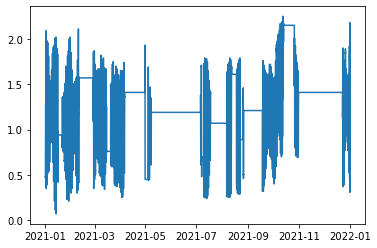

In [28]:
plt.plot(x,y)
plt.show()

### S-1 查看指定时间段

In [89]:
start=datetime.datetime(2021,1,1)
end=datetime.datetime(2021,2,1)

In [90]:
dfs=inter_rad_month(start,end,reslt_all_df)

C:\Users\evase\Anaconda3\envs\new_oil_gdal\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [91]:
dfs[0].head()

,index,dt_x,ts,Unnamed: 0,dt_y,rad
1,1.0,2021-01-01 00:01:00+00:00,1609459260,0.0,2021-01-01 00:01:00+00:00,0.48
2,2.0,2021-01-01 00:02:00+00:00,1609459320,1.0,2021-01-01 00:02:00+00:00,0.48
3,3.0,2021-01-01 00:03:00+00:00,1609459380,2.0,2021-01-01 00:03:00+00:00,0.47
4,4.0,2021-01-01 00:04:00+00:00,1609459440,3.0,2021-01-01 00:04:00+00:00,0.47
5,5.0,2021-01-01 00:05:00+00:00,1609459500,4.0,2021-01-01 00:05:00+00:00,0.47


In [60]:
dfs[1].head()

,index,dt_x,ts,Unnamed: 0,dt_y,rad
1,1.0,2021-01-01 00:01:00+00:00,1609459260,0.0,2021-01-01 00:01:00+00:00,0.48
2,2.0,2021-01-01 00:02:00+00:00,1609459320,1.0,2021-01-01 00:02:00+00:00,0.48
3,3.0,2021-01-01 00:03:00+00:00,1609459380,2.0,2021-01-01 00:03:00+00:00,0.47
4,4.0,2021-01-01 00:04:00+00:00,1609459440,3.0,2021-01-01 00:04:00+00:00,0.47
5,5.0,2021-01-01 00:05:00+00:00,1609459500,4.0,2021-01-01 00:05:00+00:00,0.47


In [92]:
start_filter=datetime.datetime(2021,1,10)
end_filter=datetime.datetime(2021,1,15)
start_filter_pd_ts=pd.Timestamp(start_filter)
start_filter_ts=start_filter_pd_ts.timestamp()
end_pd_ts=pd.Timestamp(end_filter)
end_filter_ts=end_pd_ts.timestamp()

In [93]:
dfs_source=dfs[0]

In [94]:
con1=dfs_source['ts']>start_filter_ts
con2=dfs_source['ts']<end_filter_ts

In [95]:
dfs_source_res=dfs_source[con1&con2]

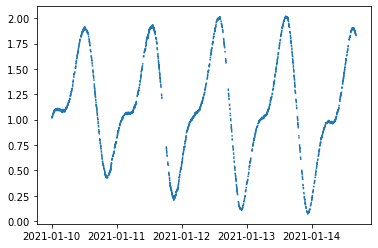

In [96]:
plt.plot(dfs_source_res['dt_x'],dfs_source_res['rad'])
plt.show()


In [97]:
dfs_inter=dfs[1]

In [98]:
con1=dfs_inter['ts']>start_filter_ts
con2=dfs_inter['ts']<end_filter_ts
dfs_inter_res=dfs_inter[con1&con2]

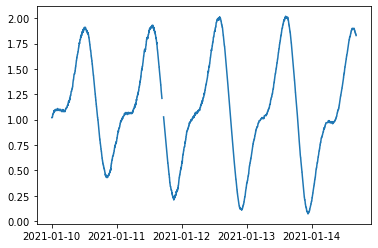

In [99]:
plt.plot(dfs_inter_res['dt_x'],dfs_inter_res['rad'])
plt.show()